# Import packages

In [273]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import random
global_lambdas = []
global_gammas = []

# Generate data

In [301]:
mu, sigma = 0, 1 # mean and standard deviation
N = 100000

### Generate z_vec

Generate vector z of hidden states as follows:

$$z_{i} = \gamma z_{i-1} + \delta_i \hspace{0.5cm} \text{with } z_0 = 0, \hspace{0.2cm} \gamma = 0.5, \hspace{0.2cm} \delta = norm(0, 1)$$

In [302]:
z0 = 0
gamma = 0.1
delta = np.random.normal(mu, sigma, N)
z_vec = []
z_vec.append(gamma*z0 + delta[0])
for i in range(1, N):
    z_vec.append(gamma*z_vec[i-1] + delta[i])  

# convert to np array
z_vec = np.array(z_vec)

### Generate x_vec

Generate vector x of observations as follows:

$$x_{i} = norm(z_{i},1) \hspace{0.5cm}$$

In [303]:
x_vec = []
for i in range(N):
#     x_i = np.random.normal(z_vec[i], sigma)
    x_i = z_vec[i]
    x_vec.append(x_i)

# convert to np array
x_vec = np.array(x_vec)

# Algorithm

$$ \underset{z}{min} \sum_{i} \left[\left(x_i - z_i \right)^2 + \lambda \left(z_i - \gamma z_{i-1}\right)^2\right]$$

Taking derivative over $z_i$ gives us:
$$-2\lambda \gamma z_{i-1} + (2 + 2\lambda - 2\gamma^2\lambda) - 2\lambda \gamma z_{i+1} = 2x_i$$

LU decomposition of the tridiagonal matrix gives us the following system of equations:

\begin{equation}
    \begin{split}
        & t_1 = v = 2 + 2\lambda - 2\gamma^2\lambda, \hspace{1cm} u = r_jt_{j-1} = - 2\lambda \gamma \\
        & \begin{cases} v = r_ju + t_j \hspace{0.1cm} \text{if} \hspace{0.1cm} j \le m \\  2 + 2 \lambda = r_ju + t_j \hspace{0.1cm} \text{if} \hspace{0.1cm} j = m\end{cases}
    \end{split}
\end{equation}


**Step 1**: Estimate $\gamma$ using LU decomposition

**Step 2**: Estimate $z$ from the just-found $\gamma$

In [304]:
def step_one(lmda, gamma, x_vec, N, z=None):
    
    u = -2*lmda*gamma
    v = 2 + 2*lmda + 2*lmda*(gamma**2)
    c_vec = 2*x_vec
    r_vec = []
    t_vec = []
    t_vec.append(v)
    # calculate LU
    for i in range(N):
        r_vec.append(u/t_vec[i])
        if i < N-1:
            t_vec.append(v-r_vec[i]*u)
        else:
            t_vec.append(2+2*lmda-r_vec[i]*u)
    
    # Az = C -> LUz = C, let Uz = D -> LD = C
    d_vec = []
    d_vec.append(c_vec[0])
    for i in range(1, N):
        d_vec.append(c_vec[i] - r_vec[i-1]*d_vec[i-1])
    
    # Calculate z
    found_z = []
    found_z.append(d_vec[N-1]/t_vec[N-1])
    for i in range (N-2, -1, -1):
        z_i = (d_vec[i] - u*found_z[len(found_z)-1])/t_vec[i]
        found_z.append(z_i)
    found_z.reverse()
    z = np.array(z, dtype='float')
    found_z = np.array(found_z, dtype='float')
    
    MSE = None
    if z is not None:
        MSE = np.sum((z - found_z)**2)/N
    return found_z, MSE

In [305]:
def step_two(z):
    Z = []
    Z.append(z0)
    for i in range(N-1):
        Z.append(z[i])
    Z = np.matrix(Z, dtype='float')
    ZZ = np.matmul(Z, Z.transpose())
    ZZ = np.linalg.pinv(ZZ)
    ZZ_vec = np.matmul(Z, z.transpose())
    gamma_vec = ZZ*ZZ_vec
    gamma = gamma_vec.item(0)
    return gamma

In [306]:
def repeat_until_convergence(lmda, x_vec, z_vec, threshold):
    gamma = random.randrange(0,1)
    iteration = 0
    while True:
        if iteration == 0:
            z = None
        else:
            z = found_z
        found_z, MSE = step_one(lmda, gamma, x_vec, N, z)
        gamma = step_two(found_z)
        iteration += 1
        print(MSE)
        if MSE != None and MSE < threshold:
            gammas.append(gamma)
            print("When lmda is", lmda, ", the found gamma is:", gamma)
            break

In [307]:
lambdas = [0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gammas = []
for lmda in lambdas:
    threshold = 0.000000001
    repeat_until_convergence(lmda, x_vec, z_vec, threshold)
    

nan
2.1674229953506897e-08
8.378020119344179e-14
When lmda is 0.001 , the found gamma is: 0.10429163167139409
nan
5.332805481859538e-07
5.1091083703353575e-11
When lmda is 0.005 , the found gamma is: 0.10511785659974451
nan
0.00014874240221324515
4.690831023292639e-06
1.4799337391469658e-07
4.66607750057335e-09
1.4709610074847167e-10
When lmda is 0.1 , the found gamma is: 0.12671551842686124
nan
0.00042086426392742545
4.4092410374716804e-05
4.566856152743468e-06
4.7076938324722076e-07
4.8449120437545686e-08
4.983442016763772e-09
5.125040008896016e-10
When lmda is 0.2 , the found gamma is: 0.15428043449668183
nan
0.000689174743343776
0.00013730331537802483
2.660670445598189e-05
5.082981828827559e-06
9.646442114961176e-07
1.8252699182468337e-07
3.4492115802958265e-08
6.514254906356746e-09
1.2299904002241262e-09
2.322157897712405e-10
When lmda is 0.3 , the found gamma is: 0.18808525251095262
nan
0.0009133634662762637
0.00027758554729835383
8.055903017081413e-05
2.2701262869843766e-05
6.28

In [308]:
print(lambdas, gammas)

[0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] [0.10429163167139409, 0.10511785659974451, 0.12671551842686124, 0.15428043449668183, 0.18808525251095262, 0.22931633995056477, 0.2784908157486466, 0.33414903319819644, 0.3925734482424555, 0.449228160484155, 0.5007706451843483, 0.5460431509786197]


In [309]:
global_lambdas.append(lambdas)
global_gammas.append(gammas)

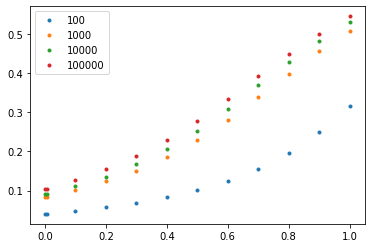

In [310]:
for i in range(len(global_lambdas)):
    plt.plot(global_lambdas[i], global_gammas[i], '.')

dt = ["100", "1000", "10000", "100000"]
plt.legend(dt)

In [40]:
print(len(global_lambdas[0]))

12
